In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

plt.rcParams['font.sans-serif'] = ['Kaiti']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 读入数据,以id列作为索引
df = pd.read_excel('某电商网站订单数据.xlsx', index_col='id')

In [3]:
# 查看数据信息
# df.head()
df.info()

# channelID列存在空值

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104557 entries, 1 to 104557
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   orderID       104557 non-null  object        
 1   userID        104557 non-null  object        
 2   goodsID       104557 non-null  object        
 3   orderAmount   104557 non-null  float64       
 4   payment       104557 non-null  float64       
 5   chanelID      104549 non-null  object        
 6   platfromType  104557 non-null  object        
 7   orderTime     104557 non-null  datetime64[ns]
 8   payTime       104557 non-null  datetime64[ns]
 9   chargeback    104557 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(6)
memory usage: 8.8+ MB


In [4]:
# 因录入信息出错，导致列名拼写有误，现做更改
df.rename(columns={'chanelID':'channelId','platfromType':'platformType'},inplace=True)
df.head()

,orderID,userID,goodsID,orderAmount,payment,channelId,platformType,orderTime,payTime,chargeback
id,,,,,,,,,,
1,sys-2018-254118088,user-157213,PR000064,272.51,272.51,渠道-0396,APP,2018-02-14 12:20:36,2019-02-28 13:38:41,否
2,sys-2018-263312190,user-191121,PR000583,337.93,337.93,渠道-0765,Wech atMP,2018-08-14 09:40:34,2019-01-01 14:47:14,是
3,sys-2018-188208169,user-211918,PR000082,905.68,891.23,渠道-0530,We c hatMP,2018-11-02 20:17:25,2019-01-19 20:06:35,否
4,sys-2018-203314910,user-201322,PR000302,786.27,688.88,渠道-0530,WEB,2018-11-19 10:36:39,2019-08-07 12:24:35,否
5,sys-2018-283989279,user-120872,PR000290,550.77,542.51,渠道-9527,APP,2018-12-26 11:19:16,2019-10-01 07:42:43,否


In [5]:
# 提取2019年订单数据作为分析对象

from datetime import datetime

start_time = datetime(2019,1,1)   # 设置初始年月
end_time = datetime(2019,12,31,23,59,59)   # 设置结束年月

# 将下单时间小于初始时间，大于结束时间的数据删除
df.drop(index=df[df.orderTime < start_time].index, inplace=True)
df.drop(index=df[df.orderTime > end_time].index, inplace=True)
df.head()

,orderID,userID,goodsID,orderAmount,payment,channelId,platformType,orderTime,payTime,chargeback
id,,,,,,,,,,
6,sys-2019-279103297,user-146548,PR000564,425.20,425.20,渠道-0765,Wech atMP,2019-01-01 00:12:23,2019-01-01 00:13:37,否
7,sys-2019-316686066,user-104210,PR000709,1764.37,1707.04,渠道-0396,We c hatMP,2019-01-01 00:23:06,2019-01-01 00:23:32,否
8,sys-2019-306447069,user-104863,PR000499,499.41,480.42,渠道-0007,Wech atMP,2019-01-01 01:05:50,2019-01-01 01:06:17,否
9,sys-2019-290267674,user-206155,PR000253,1103.00,1050.95,渠道-0330,APP,2019-01-01 01:16:12,2019-01-01 01:16:25,否
10,sys-2019-337079027,user-137939,PR000768,465.41,465.41,渠道-9527,AL i MP,2019-01-01 01:31:00,2019-01-01 01:31:36,否


In [6]:
# 处理业务流程不符的数据（支付时间早于下单时间、支付时长超过30分钟、订单金额小于0、支付金额小于0）

df.drop(index=df[df.payTime < df.orderTime].index, inplace=True)

delta = (df.payTime - df.orderTime)
df.drop(index=df[(delta.dt.days > 0) | (delta.dt.seconds > 1800)].index, inplace=True)

df.drop(index=df[(df.orderAmount <0 ) | (df.payment < 0)].index,inplace=True)



In [7]:
# 处理渠道为空的数据（以众数填补）

df.channelId.fillna(df.channelId.mode()[0], inplace=True)

In [8]:
# 处理平台类型字段，去除多余空格，保持数据一致，并转换为小写

# 使用正则表达式进行查找替换
df['platformType'] = df.platformType.str.replace(r'\s','',regex=True).str.lower()

In [9]:
# 根据下单金额与实付金额，计算折扣率
df['discount'] = df.payment / df.orderAmount  # 计算折扣率
mean_discount = df[df.discount <= 1]['discount'].mean()   # 计算折扣率小于等于1的均值

# 将折扣率大于1的实付金额用下单金额，平均折扣率重写实付金额
df['payment'] = df.payment.mask(df.discount > 1, df.orderAmount * mean_discount)

# 检查是否符合标准
df[df.payment > df.orderAmount].index

Int64Index([], dtype='int64', name='id')

In [10]:
# 计算交易总金额，总销售额， 实际销售额，退货率，客单价

gmv = df.orderAmount.sum()   # 交易总金额
total_sales = df.payment.sum()  # 总销售额
real_sales = df[df.chargeback == '否'].payment.sum()  # 实际销售额
refund_rate = df[df.chargeback=='是'].orderID.count() / df.orderID.count()  # 退货率
arpu = real_sales / df.userID.nunique()  # 客单价

print(f'GMV: {gmv}')
print(f'总销售额: {total_sales}')
print(f'实际销售额: {real_sales}')
print(f'退货率: {refund_rate*100:.2f}%')
print(f'客单价: {arpu}')

GMV: 108527205.98999998
总销售额: 102630360.28680262
实际销售额: 88940437.70922612
退货率: 13.18%
客单价: 1130.8239909120814


In [11]:
# 按月计算GMV、总销售额，实际销售额及趋势分析（折线图）

df['month'] = df.orderTime.dt.month  # 新增列记录月

months = [f'{x}月' for x in range(1,13)]  # 将1-12月存入一个列表中

# 按月计算单位万元
gmv_ser = np.round(df.groupby('month').orderAmount.sum() / 10000 ,2)  # 各月总交易金额
total_sales_ser = np.round(df.groupby('month').payment.sum() /10000,2)  # 各月总销售额
real_sales_ser = np.round(df[df.chargeback=='否'].groupby('month').payment.sum() /10000,2) # 各月实际销售额


In [12]:
# 使用pyecharts进行绘制折线图

import pyecharts.options as opts
from pyecharts.charts import Line

line = Line(init_opts=opts.InitOpts(width="750px", height="400px"))
line.add_xaxis(xaxis_data=months)
line.add_yaxis(
        series_name="gmv",
        y_axis=gmv_ser,
        ),

line.add_yaxis(
        series_name="销售额",
        y_axis=total_sales_ser,
    )

line.add_yaxis(
        series_name="实际销售额",
        y_axis=real_sales_ser,
    )

line.set_global_opts(
        title_opts=opts.TitleOpts(title="2019年每月指标走势", subtitle=""),
        tooltip_opts=opts.TooltipOpts(trigger="axis"),

        xaxis_opts=opts.AxisOpts(type_="category", boundary_gap=False),
    )
line.render_notebook()

In [13]:
# 按渠道拆解GMV占比（饼图）
from pyecharts.charts import Pie



# 按渠道拆解计算GMV取前十
channel_gmv = df.groupby('channelId')['orderAmount'].sum().nlargest(10)


c = (
    Pie()
    .add("", [list(z) for z in zip(channel_gmv.index,channel_gmv.values)])  
    .set_global_opts(title_opts=opts.TitleOpts(title="各渠道GMV贡献TOP-10"),legend_opts=opts.LegendOpts(orient="vertical", pos_top="15%", pos_left="2%"))
    .set_series_opts(label_opts=opts.LabelOpts(formatter='{b}:{d}%')
                    )
    .render_notebook()
)
c

In [14]:
from pyecharts.charts import Bar

# 周一到周日哪天的下单量最高、每天哪个时段下单量最高（柱状图）

df['weekday'] = (df.orderTime.dt.weekday+1) % 7   # 新增星期列
temp = pd.pivot_table(df,index='weekday',values='orderID',aggfunc='nunique')
x = [f'星期{x}'for x in '日一二三四五六']

c = (
    Bar()
    .add_xaxis(x)
    .add_yaxis("下单量",temp.orderID.values.tolist())
    .set_global_opts(
        title_opts=opts.TitleOpts(title="每周的下单量"),
    )
    .render_notebook()
)

c

In [15]:
# 一天中各时段的下单量

df['hour'] = df.orderTime.dt.floor('30T').dt.time  # 30分钟向下取整
temp = pd.pivot_table(df, index='hour',values='orderID',aggfunc='nunique')

delta = []
for i in temp.index:
    delta.append(i.strftime('%H:%M:%S'))
    

c = (
    Bar()
    .add_xaxis(delta)
    .add_yaxis("下单量",temp.orderID.values.tolist())
    .set_global_opts(
        title_opts=opts.TitleOpts(title="每天各时段下单量（以半小时为一段）"),
    )
    .render_notebook()
)

c

In [16]:
# 计算用户的复购率

data = df[df.chargeback=='否']
# 透视表
temp = pd.pivot_table(data,index=['userID'],columns='month',values='orderID',aggfunc='nunique')

# 创建一个找到重复购物的函数
def handle_rebuy_data(x):
    if np.isnan(x):
        return x
    return 1 if x>1 else 0

# 按月对各用户进行查询是否存在复购行为，有则设为1，无则0
temp = temp.applymap(handle_rebuy_data)
temp

month,1,2,3,4,5,6,7,8,9,10,11,12
userID,,,,,,,,,,,,
user-100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
user-100003,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user-100006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
user-100007,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user-100008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
user-299980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
user-299983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
user-299989,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [17]:
# 复购率
rebuy_rate = temp.sum() / temp.count()
# rebuy_rate.apply(lambda x: np.round())

from pyecharts.charts import Line

c = (
    Line()
    .add_xaxis(rebuy_rate.index)
    .add_yaxis(
        "复购率",
        rebuy_rate.values,
    )
    .set_global_opts(title_opts=opts.TitleOpts(title="每月的复购率趋势"))
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    .render_notebook()
)
c

In [18]:
# 构建RFM模型
df['F'] =1

temp = pd.pivot_table(df,index='userID',
              values=['orderTime','payment','F'],
              aggfunc={
                  'orderTime': np.max,
                  'payment': np.sum,
                  'F': np.sum
              })
temp

,F,orderTime,payment
userID,,,
user-100000,1,2019-10-13 18:46:46,1770.81
user-100003,1,2019-05-24 13:04:05,511.59
user-100006,2,2019-11-14 15:37:19,2771.98
user-100007,1,2019-01-14 18:45:35,2162.14
user-100008,1,2019-11-16 17:15:03,4879.94
...,...,...,...
user-299980,1,2019-10-18 10:53:37,389.44
user-299983,1,2019-12-27 17:57:11,706.80
user-299989,2,2019-11-11 10:40:08,1637.47


In [19]:
temp['R'] = (temp.orderTime-datetime(2019,12,31)).dt.days   # 最后一次购买日期离2019年最后一天相差多少天
temp['M'] = temp.payment

In [20]:
temp = temp[['R','F','M']]
temp

,R,F,M
userID,,,
user-100000,-79,1,1770.81
user-100003,-221,1,511.59
user-100006,-47,2,2771.98
user-100007,-351,1,2162.14
user-100008,-45,1,4879.94
...,...,...,...
user-299980,-74,1,389.44
user-299983,-4,1,706.80
user-299989,-50,2,1637.47


In [21]:
temp = temp.apply(lambda x: x-x.mean())
temp = temp.applymap(lambda x: '1' if x>=0 else '0')
temp

,R,F,M
userID,,,
user-100000,1,0,1
user-100003,0,0,0
user-100006,1,1,1
user-100007,0,0,1
user-100008,1,0,1
...,...,...,...
user-299980,1,0,0
user-299983,1,0,0
user-299989,1,1,1


In [22]:
# 定义不同情况下的用户分层
def make_tag(row):
    tags = {
        '111':'重要价值用户',
        '101':'重要发展客户',
        '011':'重要保持客户',
        '001':'重要挽留用户',
        '110':'一般价值用户',
        '100':'一般发展用户',
        '010':'一般保持用户',
        '000':'一般挽留用户'
    }
    r,f,m = row.values
    return tags.get(r+f+m)
    

temp['TAG'] = temp.apply(make_tag, axis=1)

In [23]:
from pyecharts.charts import Pie
tag = temp.groupby('TAG').TAG.count()
c = (
    Pie()
    .add('', [list(z) for z in zip(tag.index, tag.values)])  
    .set_global_opts(title_opts=opts.TitleOpts(title="RFM模型用户分层人数"),legend_opts=opts.LegendOpts(orient="vertical", pos_top="15%", pos_left="2%"))
    .render_notebook()
)
c


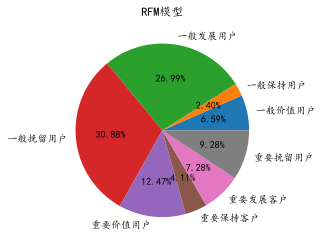

In [24]:
temp.groupby('TAG').TAG.count().plot(kind='pie',autopct='%.2f%%')
plt.ylabel('')
plt.title('RFM模型')
plt.show()